In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.datasets import fetch_california_housing
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error
from sklearn.feature_selection import VarianceThreshold

In [2]:
np.random.seed(42)

In [3]:
# data = fetch_california_housing()

In [4]:
methods = []
rmse_values = []

In [5]:
X = pd.read_parquet('data.parquet')
y = np.array(pd.read_parquet('y.parquet')['target'])

In [6]:
X.head()

,MedInc,HouseAge,AveRooms,AveBedrms,Population,AveOccup,Latitude,Longitude
0,8.3252,41.0,6.984127,1.023810,322.0,2.555556,37.88,-122.23
1,8.3014,21.0,6.238137,0.971880,2401.0,2.109842,37.86,-122.22
2,7.2574,52.0,8.288136,1.073446,496.0,2.802260,37.85,-122.24
3,5.6431,52.0,5.817352,1.073059,558.0,2.547945,37.85,-122.25
4,3.8462,52.0,6.281853,1.081081,565.0,2.181467,37.85,-122.25


In [7]:
# Создаем словари для новых признаков
constant_cols = {f'Constant_{i}': np.full(X.shape[0], i) for i in range(10)}
random_noise_cols = {f'Random_Noise_{i}': np.random.normal(size=X.shape[0]) for i in range(70)}
high_corr_cols = {f'High_Corr_{i}': X['MedInc'] * np.random.uniform(0.8, 1.2) + np.random.normal(scale=0.1, size=X.shape[0]) for i in range(20)}

# Преобразуем в DataFrame
constant_df = pd.DataFrame(constant_cols, index=X.index)
random_noise_df = pd.DataFrame(random_noise_cols, index=X.index)
high_corr_df = pd.DataFrame(high_corr_cols, index=X.index)

# Конкатенируем все новые признаки одним вызовом
X = pd.concat([X, constant_df, random_noise_df, high_corr_df], axis=1)

In [8]:
X.head()

,MedInc,HouseAge,AveRooms,AveBedrms,Population,AveOccup,Latitude,Longitude,Constant_0,Constant_1,...,High_Corr_10,High_Corr_11,High_Corr_12,High_Corr_13,High_Corr_14,High_Corr_15,High_Corr_16,High_Corr_17,High_Corr_18,High_Corr_19
0,8.3252,41.0,6.984127,1.023810,322.0,2.555556,37.88,-122.23,0,1,...,8.161325,9.685307,8.739536,9.960958,7.301636,9.056629,8.816695,9.243527,8.328207,9.686615
1,8.3014,21.0,6.238137,0.971880,2401.0,2.109842,37.86,-122.22,0,1,...,8.283293,9.488332,8.608044,9.878094,7.332774,8.894322,8.854414,9.112543,8.264935,9.627144
2,7.2574,52.0,8.288136,1.073446,496.0,2.802260,37.85,-122.24,0,1,...,7.312519,8.266549,7.715256,8.589977,6.429336,7.988969,7.724819,7.791982,7.275531,8.355280
3,5.6431,52.0,5.817352,1.073059,558.0,2.547945,37.85,-122.25,0,1,...,5.521003,6.475824,6.105654,6.642400,4.775243,6.226414,6.087473,6.163692,5.621708,6.588733
4,3.8462,52.0,6.281853,1.081081,565.0,2.181467,37.85,-122.25,0,1,...,3.788566,4.388181,4.062831,4.524889,3.372489,4.444383,4.103524,4.274153,3.792459,4.346611


In [9]:
print(f"Всего признаков: {X.shape[1]}")
print(f"Из них искусственных: 100")

Всего признаков: 108
Из них искусственных: 100


In [10]:
# Разделение данных
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

In [11]:
# Функция для оценки модели
def evaluate_model(model, X_train, X_test, y_train, y_test):
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    rmse = np.sqrt(mean_squared_error(y_test, y_pred))
    return rmse

In [12]:
# Инициализация модели
model = RandomForestRegressor(n_estimators=200, random_state=42, n_jobs=20, max_depth=30)

In [13]:
model

RandomForestRegressor(max_depth=30, n_estimators=200, n_jobs=20,
                      random_state=42)

In [14]:
# Базовое качество (все признаки)
rmse_base = evaluate_model(model, X_train, X_test, y_train, y_test)
print(f"RF, Базовое RMSE (все признаки): {rmse_base:.4f}")
methods.append('RF, Базовое качество')
rmse_values.append(rmse_base)

RF, Базовое RMSE (все признаки): 0.5538


# Без целевой переменной

## Низкая дисперсия

In [15]:
pd.options.display.float_format = '{:,.3f}'.format
# Вычисляем дисперсию, уберем 3 самые большие, чтоб соблюсти масштаб
variances = X_train.var()

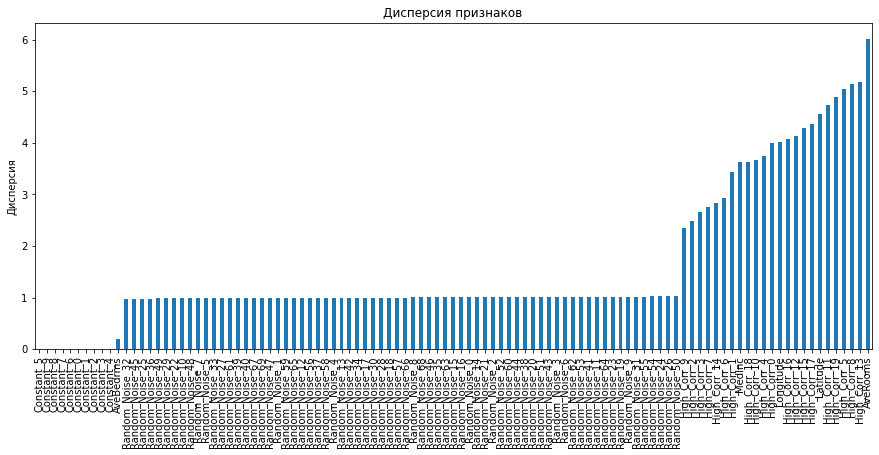

In [16]:
# Визуализация
plt.figure(figsize=(15, 6))
variances.sort_values().iloc[:-3].plot(kind='bar')
plt.title('Дисперсия признаков')
plt.ylabel('Дисперсия')
plt.show()

In [17]:
# самый консервативный порог удаляет наши константные признаки
variances.loc[variances<0.01]

Constant_0   0.000
Constant_1   0.000
Constant_2   0.000
Constant_3   0.000
Constant_4   0.000
Constant_5   0.000
Constant_6   0.000
Constant_7   0.000
Constant_8   0.000
Constant_9   0.000
dtype: float64

In [18]:
# Удаление признаков с дисперсией < 0.01
selector = VarianceThreshold(threshold=0.01)
selector.fit(X_train) 

VarianceThreshold(threshold=0.01)

In [19]:
# Получаем маску и названия сохраненных признаков
selected_mask = selector.get_support()
selected_features = X_train.columns[selected_mask]
dropped_features = set(X_train.columns) - set(selected_features)

In [20]:
# Создаем новые DataFrame с сохраненной структурой
X_train_low_var = pd.DataFrame(
    selector.transform(X_train),
    columns=selected_features,
    index=X_train.index
)
X_test_low_var = pd.DataFrame(
    selector.transform(X_test),
    columns=selected_features,
    index=X_test.index
)

In [21]:
# Оценка качества
rmse_low_var = evaluate_model(model, X_train_low_var, X_test_low_var, y_train, y_test)
print(f"RMSE после удаления низковариативных признаков: {rmse_low_var:.4f}")
print(f"Удалено признаков: {len(dropped_features)}")
print(f"Удаленные признаки: {dropped_features}")

methods.append('RF, Низкая вариативность')
rmse_values.append(rmse_low_var)

RMSE после удаления низковариативных признаков: 0.5536
Удалено признаков: 10
Удаленные признаки: {'Constant_2', 'Constant_0', 'Constant_8', 'Constant_4', 'Constant_3', 'Constant_1', 'Constant_5', 'Constant_7', 'Constant_9', 'Constant_6'}


- Может ли быть такое, что категориальный признак вы распознаете как числовой?
- Если дисперия 0, но в столбце только NaN и 1, то такой признак надо удалять?

## Корреляция

In [22]:
# Вычисление корреляции
corr_matrix = X_train_low_var.corr().abs()

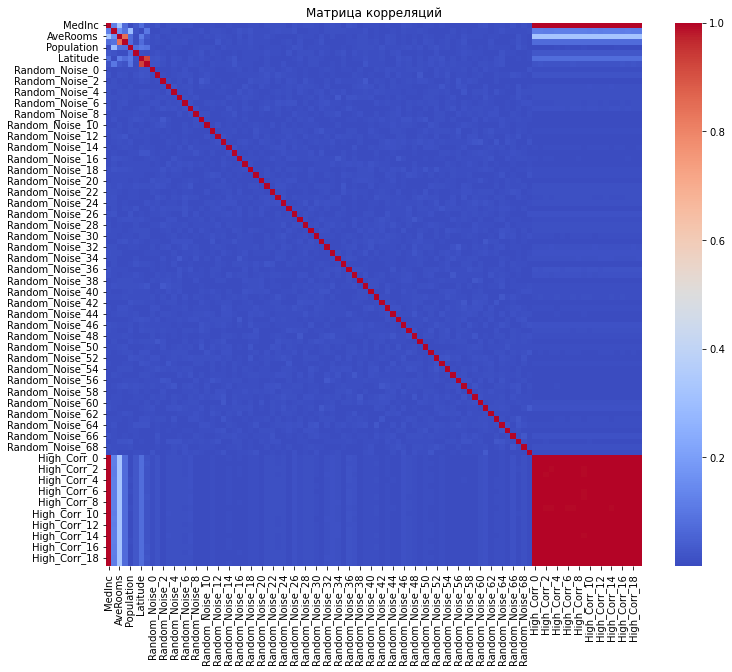

In [23]:
# Визуализация
plt.figure(figsize=(12, 10))
sns.heatmap(corr_matrix, cmap='coolwarm')
plt.title('Матрица корреляций')
plt.show()

In [24]:
# Удаление высокоскоррелированных признаков (threshold > 0.95)
upper = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(bool))
to_drop = [column for column in upper.columns if any(upper[column] > 0.95)]

In [25]:
to_drop

['High_Corr_0',
 'High_Corr_1',
 'High_Corr_2',
 'High_Corr_3',
 'High_Corr_4',
 'High_Corr_5',
 'High_Corr_6',
 'High_Corr_7',
 'High_Corr_8',
 'High_Corr_9',
 'High_Corr_10',
 'High_Corr_11',
 'High_Corr_12',
 'High_Corr_13',
 'High_Corr_14',
 'High_Corr_15',
 'High_Corr_16',
 'High_Corr_17',
 'High_Corr_18',
 'High_Corr_19']

In [26]:
X_train_uncorr = X_train_low_var.drop(columns=to_drop)
X_test_uncorr = X_test_low_var.drop(columns=to_drop)

rmse_uncorr = evaluate_model(model, X_train_uncorr, X_test_uncorr, y_train, y_test)
print(f"RMSE после удаления скоррелированных признаков: {rmse_uncorr:.4f}")
print(f"Удалено признаков: {len(to_drop)}")

methods.append('RF, Корреляция')
rmse_values.append(rmse_uncorr)

RMSE после удаления скоррелированных признаков: 0.5515
Удалено признаков: 20


# С целевой переменной

## Стат. методы фильтрации

In [27]:
from sklearn.feature_selection import f_regression, SelectKBest

https://scikit-learn.org/stable/modules/generated/sklearn.feature_selection.SelectKBest.html

Для каждого признака из X и целевой переменной 𝑦 считается: коэффициент корреляции, а затем считается статистика

In [28]:
# проверяем стат. значимость связи
selector = SelectKBest(score_func=f_regression, k=10)
selector.fit(X_train_uncorr, y_train)

SelectKBest(score_func=<function f_regression at 0x765c060f29d0>)

In [29]:
# Получаем выбранные признаки
selected_mask = selector.get_support()
selected_features = X_train_uncorr.columns[selected_mask]
dropped_features = set(X_train_uncorr.columns) - set(selected_features)

In [30]:
print("\n2. SelectKBest результаты:")
print(f"Выбрано признаков: {len(selected_features)}")
print(f"Выбранные признаки: {list(selected_features)}")
print(f"Удалённые признаки: {dropped_features}")


2. SelectKBest результаты:
Выбрано признаков: 10
Выбранные признаки: ['MedInc', 'HouseAge', 'AveRooms', 'AveBedrms', 'Population', 'AveOccup', 'Latitude', 'Longitude', 'Random_Noise_6', 'Random_Noise_61']
Удалённые признаки: {'Random_Noise_14', 'Random_Noise_23', 'Random_Noise_65', 'Random_Noise_17', 'Random_Noise_51', 'Random_Noise_32', 'Random_Noise_30', 'Random_Noise_13', 'Random_Noise_33', 'Random_Noise_56', 'Random_Noise_12', 'Random_Noise_29', 'Random_Noise_67', 'Random_Noise_66', 'Random_Noise_60', 'Random_Noise_9', 'Random_Noise_44', 'Random_Noise_48', 'Random_Noise_47', 'Random_Noise_10', 'Random_Noise_34', 'Random_Noise_21', 'Random_Noise_36', 'Random_Noise_31', 'Random_Noise_11', 'Random_Noise_2', 'Random_Noise_20', 'Random_Noise_40', 'Random_Noise_41', 'Random_Noise_28', 'Random_Noise_38', 'Random_Noise_68', 'Random_Noise_52', 'Random_Noise_7', 'Random_Noise_39', 'Random_Noise_53', 'Random_Noise_19', 'Random_Noise_25', 'Random_Noise_3', 'Random_Noise_37', 'Random_Noise_15'

In [31]:
# F-статистики и p-values
f_scores = pd.Series(selector.scores_, index=X_train_uncorr.columns)
p_values = pd.Series(selector.pvalues_, index=X_train_uncorr.columns)

In [32]:
print("\nТоп-5 признаков по F-статистике:")
print(f_scores.sort_values(ascending=False).head(5))

print("\nПризнаки с наименьшими p-values:")
print(p_values.sort_values().head(5))


Топ-5 признаков по F-статистике:
MedInc      13,000.095
AveRooms       342.144
Latitude       295.272
HouseAge       165.885
Longitude       35.264
dtype: float64

Признаки с наименьшими p-values:
MedInc      0.000
AveRooms    0.000
Latitude    0.000
HouseAge    0.000
Longitude   0.000
dtype: float64


In [33]:
X_train_kbest = selector.transform(X_train_uncorr)
X_test_kbest = selector.transform(X_test_uncorr)

In [34]:
# Для интерпретации преобразуем в DataFrame
X_train_selected = pd.DataFrame(X_train_kbest, columns=selected_features, index=X_train.index)
X_test_selected = pd.DataFrame(X_test_kbest, columns=selected_features, index=X_test.index)

In [35]:
rmse_uncorr = evaluate_model(model, X_train_selected, X_test_selected, y_train, y_test)
print(f"RMSE после отбора признаков: {rmse_uncorr:.4f}")

methods.append('RF, F-тест')
rmse_values.append(rmse_uncorr)

RMSE после отбора признаков: 0.5132


In [36]:
# Ограничения:
# - F-тест предполагает линейную зависимость и нормальность данных
# - Метод оценивает признаки по отдельности, игнорируют взаимодействия

## Embedded

### Линейная регрессия

In [37]:
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import StandardScaler

# Масштабируем данные для корректного сравнения весов
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train_uncorr)
X_test_scaled = scaler.transform(X_test_uncorr)

# Обучаем линейную регрессию
lr = LinearRegression(fit_intercept=True)
lr.fit(X_train_scaled, y_train)

# Получаем веса
weights = pd.Series(lr.coef_, index=X_train_uncorr.columns)

In [38]:
weights

MedInc             0.849
HouseAge           0.122
AveRooms          -0.299
AveBedrms          0.348
Population        -0.001
                   ...  
Random_Noise_65    0.001
Random_Noise_66   -0.005
Random_Noise_67   -0.000
Random_Noise_68   -0.004
Random_Noise_69    0.000
Length: 78, dtype: float64

In [39]:
weights.abs().sort_values(ascending=False).head(10)

Latitude          0.894
Longitude         0.869
MedInc            0.849
AveBedrms         0.348
AveRooms          0.299
HouseAge          0.122
AveOccup          0.041
Random_Noise_4    0.018
Random_Noise_6    0.014
Random_Noise_53   0.014
dtype: float64

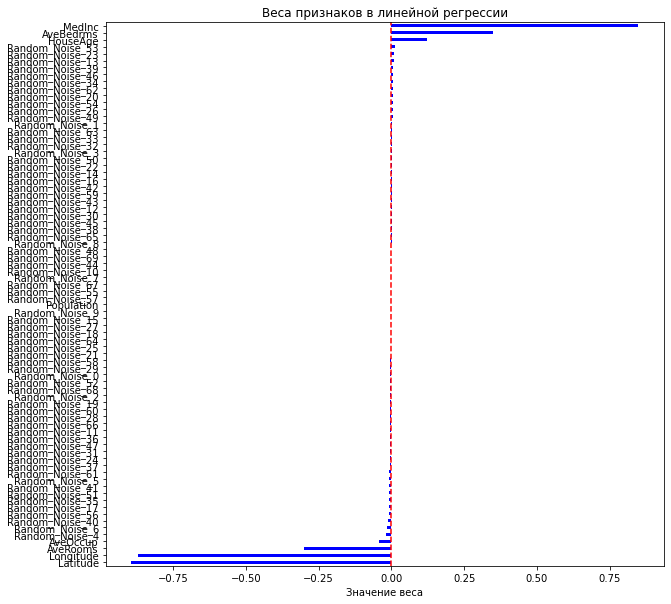

In [40]:
# Визуализация весов
plt.figure(figsize=(10, 10))
weights.sort_values().plot(kind='barh', color='blue')
plt.title('Веса признаков в линейной регрессии')
plt.xlabel('Значение веса')
plt.axvline(x=0, color='r', linestyle='--')
plt.show()

In [41]:
# Положительные веса: увеличение признака увеличивает целевую переменную"
# Отрицательные веса: увеличение признака уменьшает целевую переменную"

In [42]:
# Качество модели
y_pred_lr = lr.predict(X_test_scaled)
rmse_lr = np.sqrt(mean_squared_error(y_test, y_pred_lr))
print(f"\nRMSE линейной регрессии (все признаки): {rmse_lr:.4f}")


RMSE линейной регрессии (все признаки): 0.7293


In [43]:
methods.append('LR')
rmse_values.append(rmse_lr)

In [44]:
# Выбираем 5 признаков с наибольшим абсолютным весом
top5_features = weights.abs().sort_values(ascending=False).head(5).index
print(f"\nТоп-5 признаков по важности (абсолютные веса): {list(top5_features)}")


Топ-5 признаков по важности (абсолютные веса): ['Latitude', 'Longitude', 'MedInc', 'AveBedrms', 'AveRooms']


In [45]:
# Обучаем модель только на этих признаках
X_train_top5 = X_train_scaled[:, [weights.index.get_loc(f) for f in top5_features]]
X_test_top5 = X_test_scaled[:, [weights.index.get_loc(f) for f in top5_features]]

lr_top5 = LinearRegression()
lr_top5.fit(X_train_top5, y_train)
y_pred_top5 = lr_top5.predict(X_test_top5)
rmse_top5 = np.sqrt(mean_squared_error(y_test, y_pred_top5))
print(f"RMSE на топ-5 признаках: {rmse_top5:.4f}")

RMSE на топ-5 признаках: 0.7370


In [46]:
methods.append('LR, top_5')
rmse_values.append(rmse_top5)

### Lasso

In [47]:
from sklearn.linear_model import LassoCV

In [48]:
# Lasso с кросс-валидацией для подбора alpha
# Неявно подбирает alpha по умолчанию на логарифмической сетке, но сам диапазон можно контролировать через параметр alphas
lasso = LassoCV(cv=5, random_state=42, max_iter=10000)
lasso.fit(X_train_scaled, y_train)

LassoCV(cv=5, max_iter=10000, random_state=42)

In [49]:
# Коэффициенты Lasso
lasso_coef = pd.Series(lasso.coef_, index=X_train_uncorr.columns)

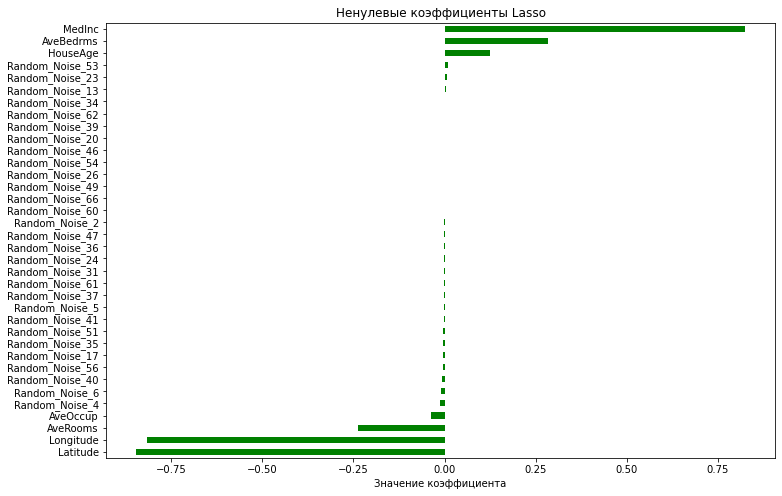

In [50]:
# Визуализация
plt.figure(figsize=(12, 8))
lasso_coef[lasso_coef != 0].sort_values().plot(kind='barh', color='green')
plt.title('Ненулевые коэффициенты Lasso')
plt.xlabel('Значение коэффициента')
plt.show()

In [51]:
# Отобранные признаки
selected_lasso = lasso_coef[lasso_coef != 0].index
print(f"\nLasso выбрал {len(selected_lasso)} признаков: {list(selected_lasso)}")


Lasso выбрал 36 признаков: ['MedInc', 'HouseAge', 'AveRooms', 'AveBedrms', 'AveOccup', 'Latitude', 'Longitude', 'Random_Noise_2', 'Random_Noise_4', 'Random_Noise_5', 'Random_Noise_6', 'Random_Noise_13', 'Random_Noise_17', 'Random_Noise_20', 'Random_Noise_23', 'Random_Noise_24', 'Random_Noise_26', 'Random_Noise_31', 'Random_Noise_34', 'Random_Noise_35', 'Random_Noise_36', 'Random_Noise_37', 'Random_Noise_39', 'Random_Noise_40', 'Random_Noise_41', 'Random_Noise_46', 'Random_Noise_47', 'Random_Noise_49', 'Random_Noise_51', 'Random_Noise_53', 'Random_Noise_54', 'Random_Noise_56', 'Random_Noise_60', 'Random_Noise_61', 'Random_Noise_62', 'Random_Noise_66']


In [52]:
# Качество модели
y_pred_lasso = lasso.predict(X_test_scaled)
rmse_lasso = np.sqrt(mean_squared_error(y_test, y_pred_lasso))
print(f"RMSE Lasso: {rmse_lasso:.4f}")
print(f"Улучшение по сравнению с полной моделью: {rmse_lr - rmse_lasso:.4f}")

RMSE Lasso: 0.7268
Улучшение по сравнению с полной моделью: 0.0025


In [53]:
methods.append('Lasso')
rmse_values.append(rmse_lasso)

### Feature Importance

In [54]:
rf = RandomForestRegressor(n_estimators=100, random_state=42, n_jobs=10)
rf.fit(X_train_uncorr, y_train)

RandomForestRegressor(n_jobs=10, random_state=42)

In [55]:
# Визуализация важности
importances = pd.Series(rf.feature_importances_, index=X_train_uncorr.columns)
importances = importances.sort_values(ascending=False)

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


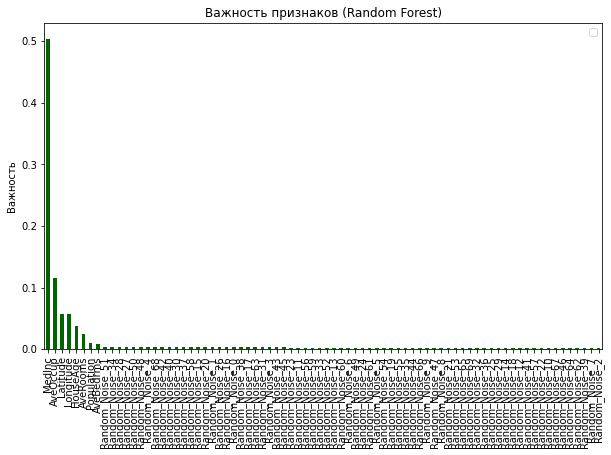

In [56]:
plt.figure(figsize=(10, 6))
importances.plot(kind='bar', color='darkgreen')
plt.title('Важность признаков (Random Forest)')
plt.ylabel('Важность')
# plt.axhline(y=0.01, color='r', linestyle='--', label='Порог важности (0.01)')
plt.legend()
plt.show()

In [57]:
importances.sum()

1.0

In [58]:
importances[importances>0.004]

MedInc       0.504
AveOccup     0.115
Latitude     0.058
Longitude    0.058
HouseAge     0.037
AveRooms     0.025
Population   0.010
AveBedrms    0.009
dtype: float64

In [59]:
# Удаляем неинформативные признаки
to_keep = importances[importances > 0.004].index
X_train_imp = X_train_uncorr[to_keep]
X_test_imp = X_test_uncorr[to_keep]

rmse_imp = evaluate_model(model, X_train_imp, X_test_imp, y_train, y_test)
print(f"4. RMSE после отбора по важности: {rmse_imp:.4f}")

4. RMSE после отбора по важности: 0.5042


In [60]:
methods.append('RF, отбор по важности')
rmse_values.append(rmse_imp)

In [61]:
from catboost import CatBoostRegressor

In [62]:
cb = CatBoostRegressor(random_state=42)
cb.fit(X_train_uncorr, y_train)

Learning rate set to 0.062435
0:	learn: 1.1175873	total: 54.3ms	remaining: 54.3s
1:	learn: 1.0812637	total: 60.8ms	remaining: 30.3s
2:	learn: 1.0491352	total: 67.4ms	remaining: 22.4s
3:	learn: 1.0191358	total: 73.9ms	remaining: 18.4s
4:	learn: 0.9868957	total: 80.3ms	remaining: 16s
5:	learn: 0.9586124	total: 86.6ms	remaining: 14.3s
6:	learn: 0.9347721	total: 93ms	remaining: 13.2s
7:	learn: 0.9107275	total: 99.3ms	remaining: 12.3s
8:	learn: 0.8884316	total: 106ms	remaining: 11.7s
9:	learn: 0.8684181	total: 112ms	remaining: 11.1s
10:	learn: 0.8496528	total: 118ms	remaining: 10.6s
11:	learn: 0.8325566	total: 124ms	remaining: 10.2s
12:	learn: 0.8152607	total: 130ms	remaining: 9.85s
13:	learn: 0.8009520	total: 135ms	remaining: 9.54s
14:	learn: 0.7839065	total: 141ms	remaining: 9.27s
15:	learn: 0.7686099	total: 147ms	remaining: 9.03s
16:	learn: 0.7572747	total: 152ms	remaining: 8.8s
17:	learn: 0.7455354	total: 158ms	remaining: 8.6s
18:	learn: 0.7351918	total: 163ms	remaining: 8.41s
19:	learn

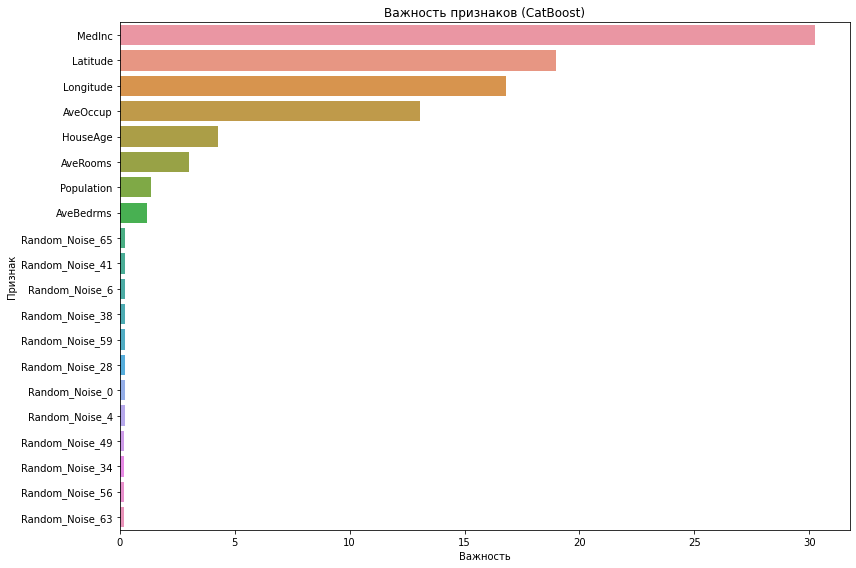

In [63]:
# Получение важности признаков
feature_importances = cb.get_feature_importance()
feature_names = X_train_uncorr.columns

# Создание DataFrame
importance_df = pd.DataFrame({
    'Feature': feature_names,
    'Importance': feature_importances
}).sort_values('Importance', ascending=False)

# Визуализация
plt.figure(figsize=(12, 8))
sns.barplot(x='Importance', y='Feature', data=importance_df.head(20))
plt.title('Важность признаков (CatBoost)')
plt.xlabel('Важность')
plt.ylabel('Признак')
plt.tight_layout()
plt.show()

# Перебор
RFE (Recursive Feature Elimination)

In [64]:
from sklearn.feature_selection import RFECV

In [65]:
# Используем RFECV для автоматического выбора оптимального числа признаков
rfecv = RFECV(
    estimator=LinearRegression(),
    step=1,
    cv=5,
    scoring='neg_mean_squared_error',
    min_features_to_select=5
)
rfecv.fit(X_train_scaled, y_train)

RFECV(cv=5, estimator=LinearRegression(), min_features_to_select=5,
      scoring='neg_mean_squared_error')

- модель (здесь LinearRegression) обучается на полном наборе признаков.
- по весам модели определяется, насколько важен каждый признак.
- удаляется наименее важный признак.
- для каждого уменьшенного набора признаков с помощью кросс-валидации оценивается качество модели по метрике
- шаги 2–5 повторяются, пока не останется min_features_to_select  признаков.

- выбирается количество признаков, при котором качество (средняя метрика по CV) лучше всего.

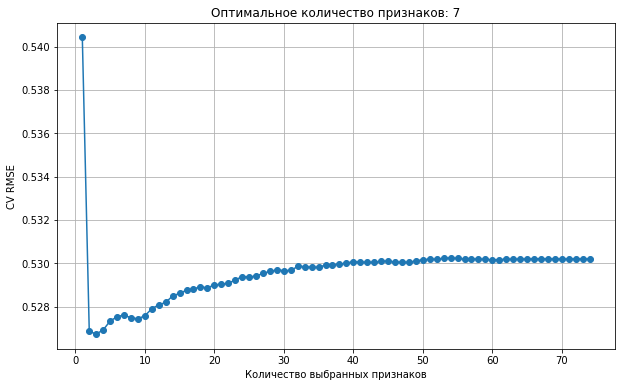

In [66]:
# Визуализация процесса отбора
plt.figure(figsize=(10, 6))
plt.plot(range(1, len(rfecv.cv_results_['mean_test_score']) + 1), 
         -rfecv.cv_results_['mean_test_score'], 'o-')
plt.xlabel("Количество выбранных признаков")
plt.ylabel("CV RMSE")
plt.title("Оптимальное количество признаков: {}".format(rfecv.n_features_))
plt.grid(True)
plt.show()

In [67]:
# Результаты
print("Оптимальное количество признаков:", rfecv.n_features_)
selected_rfecv = X_train_uncorr.columns[rfecv.support_]
print("Отобранные признаки:", list(selected_rfecv))

Оптимальное количество признаков: 7
Отобранные признаки: ['MedInc', 'HouseAge', 'AveRooms', 'AveBedrms', 'AveOccup', 'Latitude', 'Longitude']


In [68]:
# Качество на тесте
X_test_rfecv = rfecv.transform(X_test_scaled)
y_pred_rfecv = rfecv.estimator_.predict(X_test_rfecv)
rmse_rfecv = np.sqrt(mean_squared_error(y_test, y_pred_rfecv))
print(f"RMSE RFECV: {rmse_rfecv:.4f}")

RMSE RFECV: 0.7284


In [69]:
methods.append('LR, RFECV')
rmse_values.append(rmse_rfecv)

# Boruta

Boruta — это метод жадного отбора признаков, основанный на сравнении важности признаков с "шумовыми" копиями.

- Создаются теневые признаки (shadow features) — случайно перемешанные версии исходных признаков.
- Обучается случайный лес на расширенном наборе (оригинальные + теневые признаки).
- Для каждого признака вычисляется важность (feature importance).
- Признак считается значимым, если его важность статистически выше, чем максимальная важность теневых признаков.
- Признаки, значимость которых не подтверждается — отклоняются.
- Итерации повторяются, пока не останутся только значимые признаки или не достигнут лимиты по времени/итерациям.

In [70]:
# pip install shap

In [71]:
from boruta import BorutaPy

In [72]:
# Инициализация Boruta
boruta = BorutaPy(
    estimator=model, # Любую модель c методам .fit(X, y) и .feature_importances_ или .coef_
    n_estimators='auto',
    max_iter=50,  # Количество итераций
    verbose=1,    
    random_state=42
)

In [73]:
X_np = X_train_uncorr.values
y_np = y_train

In [74]:
# Запуск Boruta
boruta.fit(X_np, y_np)

Iteration: 1 / 50
Iteration: 2 / 50
Iteration: 3 / 50
Iteration: 4 / 50
Iteration: 5 / 50
Iteration: 6 / 50
Iteration: 7 / 50
Iteration: 8 / 50
Iteration: 9 / 50
Iteration: 10 / 50
Iteration: 11 / 50
Iteration: 12 / 50
Iteration: 13 / 50
Iteration: 14 / 50
Iteration: 15 / 50
Iteration: 16 / 50
Iteration: 17 / 50
Iteration: 18 / 50
Iteration: 19 / 50
Iteration: 20 / 50
Iteration: 21 / 50
Iteration: 22 / 50
Iteration: 23 / 50
Iteration: 24 / 50
Iteration: 25 / 50
Iteration: 26 / 50
Iteration: 27 / 50
Iteration: 28 / 50
Iteration: 29 / 50
Iteration: 30 / 50
Iteration: 31 / 50
Iteration: 32 / 50
Iteration: 33 / 50
Iteration: 34 / 50
Iteration: 35 / 50
Iteration: 36 / 50
Iteration: 37 / 50
Iteration: 38 / 50
Iteration: 39 / 50
Iteration: 40 / 50
Iteration: 41 / 50
Iteration: 42 / 50
Iteration: 43 / 50
Iteration: 44 / 50
Iteration: 45 / 50
Iteration: 46 / 50
Iteration: 47 / 50
Iteration: 48 / 50
Iteration: 49 / 50


BorutaPy finished running.

Iteration: 	50 / 50
Confirmed: 	8
Tentative: 	0


BorutaPy(estimator=RandomForestRegressor(max_depth=30, n_estimators=14,
                                         n_jobs=20,
                                         random_state=RandomState(MT19937) at 0x765BF3A67840),
         max_iter=50, n_estimators='auto',
         random_state=RandomState(MT19937) at 0x765BF3A67840, verbose=1)

In [75]:
# Получаем результаты
selected_mask = boruta.support_
ranking = boruta.ranking_
selected_features = X_train_uncorr.columns[selected_mask].tolist()

In [76]:
boruta_df = pd.DataFrame({
        'Feature': X_train_uncorr.columns,
        'Ranking': ranking,
        'Selected': selected_mask
    }).sort_values('Ranking')

In [77]:
boruta_df.head(10)

,Feature,Ranking,Selected
0,MedInc,1,True
1,HouseAge,1,True
2,AveRooms,1,True
3,AveBedrms,1,True
4,Population,1,True
5,AveOccup,1,True
6,Latitude,1,True
7,Longitude,1,True
59,Random_Noise_51,2,False
42,Random_Noise_34,3,False


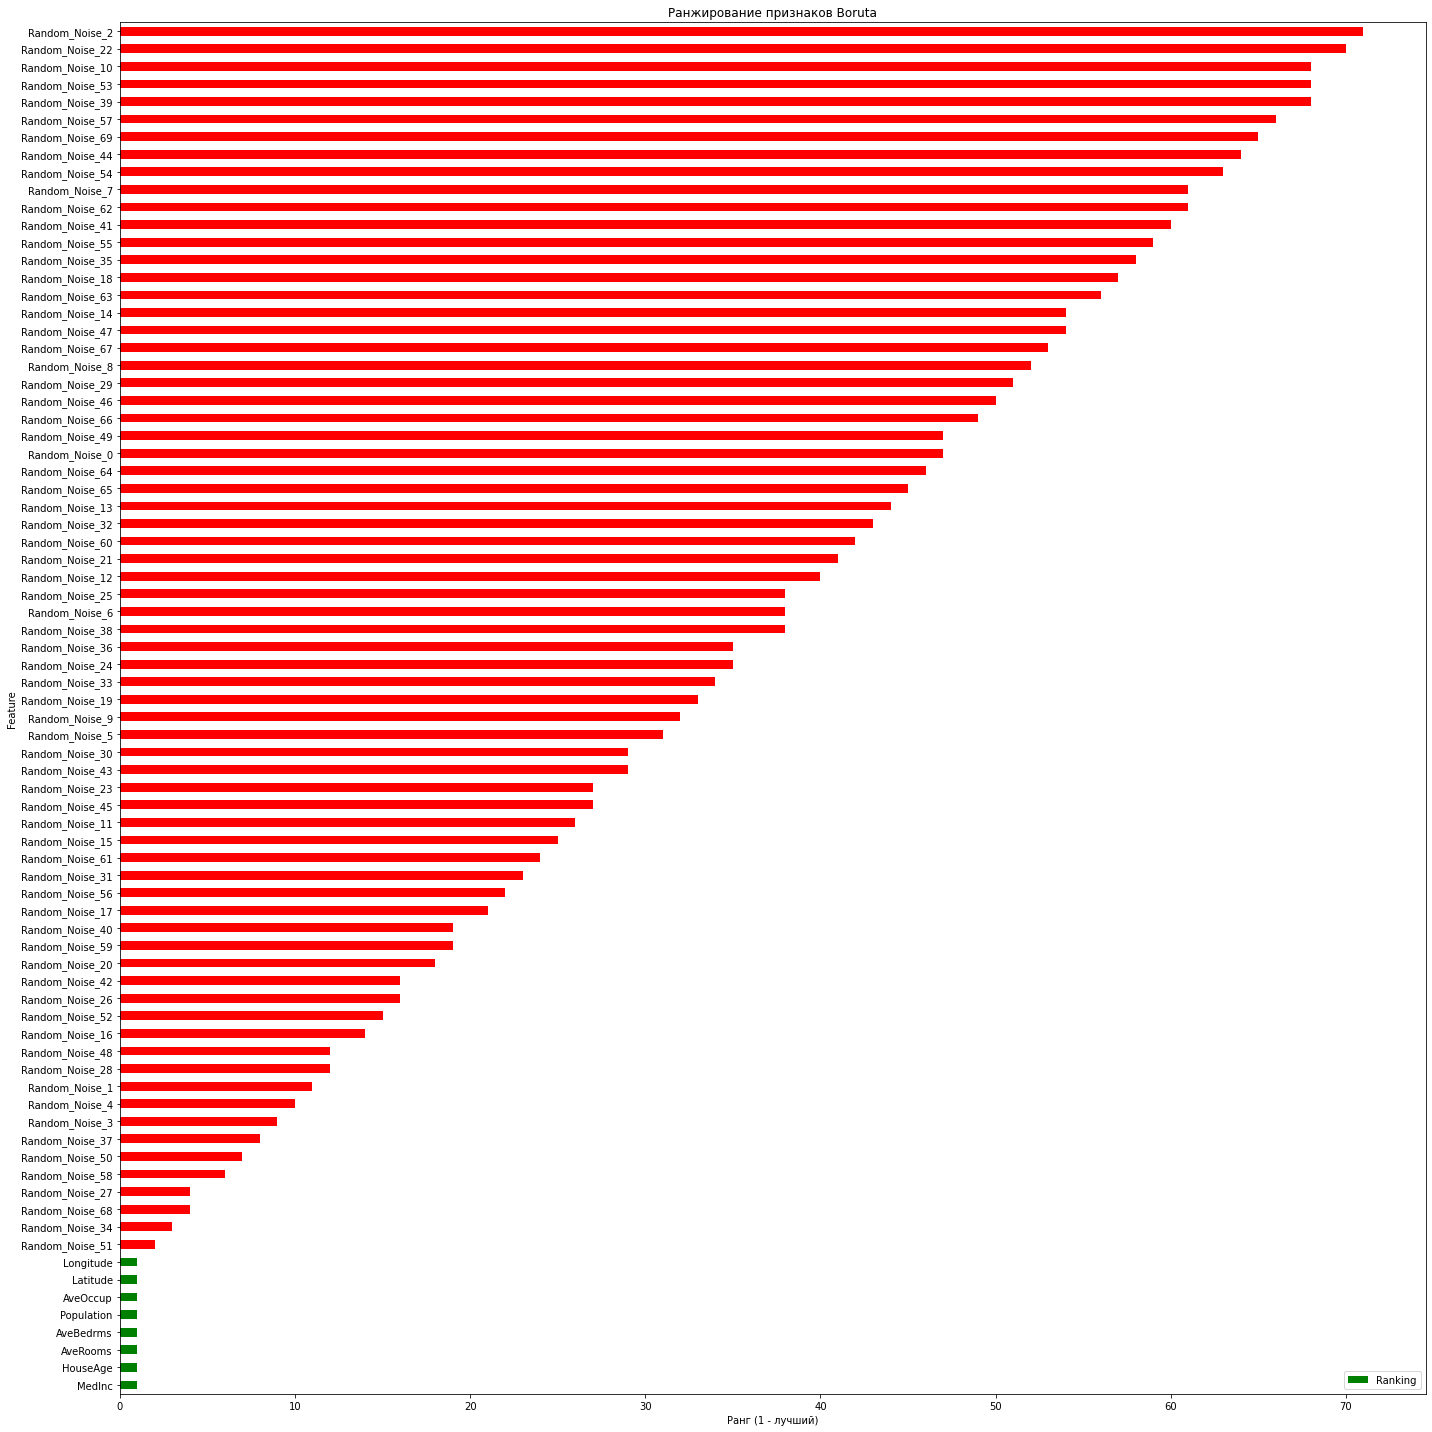

In [78]:
boruta_df.sort_values('Ranking').plot(
    kind='barh', 
    x='Feature', 
    y='Ranking', 
    legend=False,
    color=boruta_df['Selected'].map({True: 'green', False: 'red'}),
    figsize=(20, 20)
)
plt.title('Ранжирование признаков Boruta')
plt.xlabel('Ранг (1 - лучший)')
plt.legend()
plt.tight_layout()
plt.show()

In [79]:
print(f"Boruta выбрал признаки: {selected_features}")

Boruta выбрал признаки: ['MedInc', 'HouseAge', 'AveRooms', 'AveBedrms', 'Population', 'AveOccup', 'Latitude', 'Longitude']


In [80]:
X_train_boruta = X_train_uncorr[selected_features]
X_test_boruta = X_test_uncorr[selected_features]
rmse_boruta = evaluate_model(model, X_train_boruta, X_test_boruta, y_train, y_test)
print(f"RMSE после отбора Boruta: {rmse_boruta:.4f}")

RMSE после отбора Boruta: 0.5217


# SHAP

- https://shap.readthedocs.io/en/latest/
- https://habr.com/ru/companies/wunderfund/articles/739744/

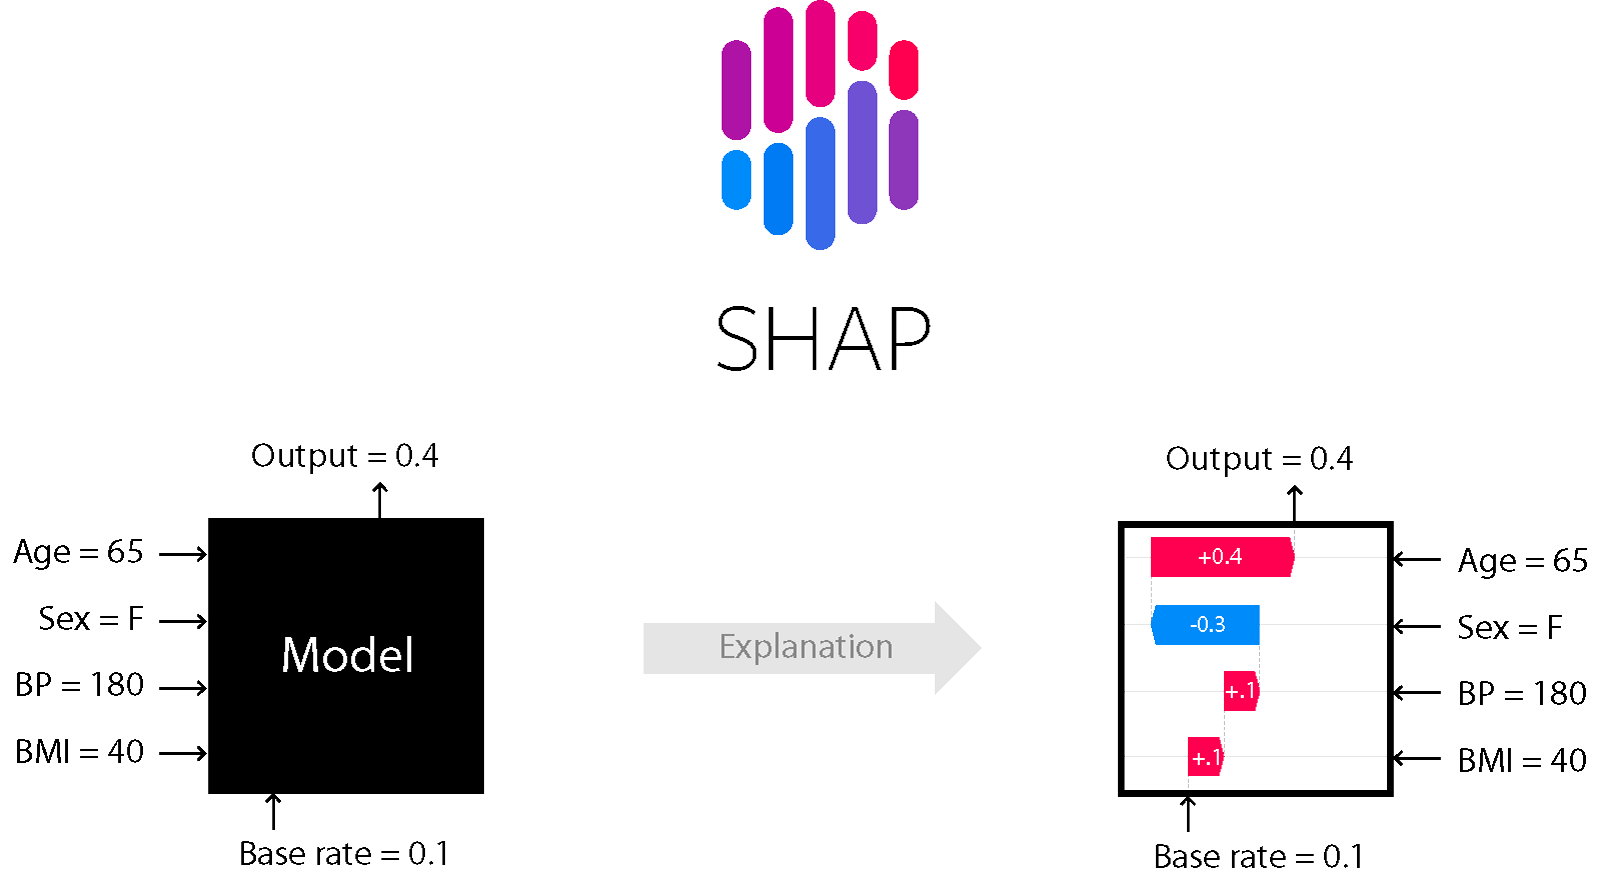

- SHAP (SHapley Additive exPlanations) — метод объяснения моделей машинного обучения на основе теории кооперативных игр (Shapley values).
- Для каждого объекта и каждого признака SHAP вычисляет, насколько этот признак вносит вклад в предсказание модели.

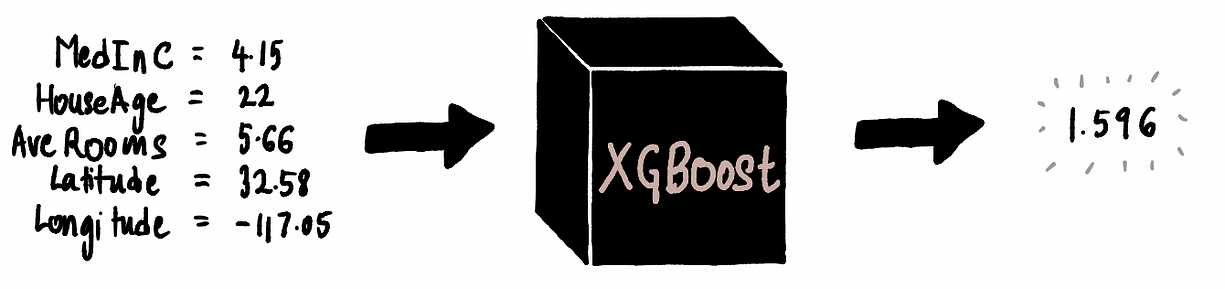

In [81]:
import shap
shap.initjs()

In [82]:
model_new = RandomForestRegressor(n_estimators=200, random_state=42, n_jobs=20, max_depth=30)
model_new.fit(X_train_uncorr, y_train)

RandomForestRegressor(max_depth=30, n_estimators=200, n_jobs=20,
                      random_state=42)

In [83]:
explainer = shap.TreeExplainer(model)

In [84]:
# Вычисляем SHAP-значения для тестового набора
shap_values = explainer.shap_values(X_test_uncorr)

/tmp/ipykernel_1315877/996752443.py:2: FutureWarning: The NumPy global RNG was seeded by calling `np.random.seed`. In a future version this function will no longer use the global RNG. Pass `rng` explicitly to opt-in to the new behaviour and silence this warning.
  shap.summary_plot(shap_values, X_test_uncorr, plot_type="dot")


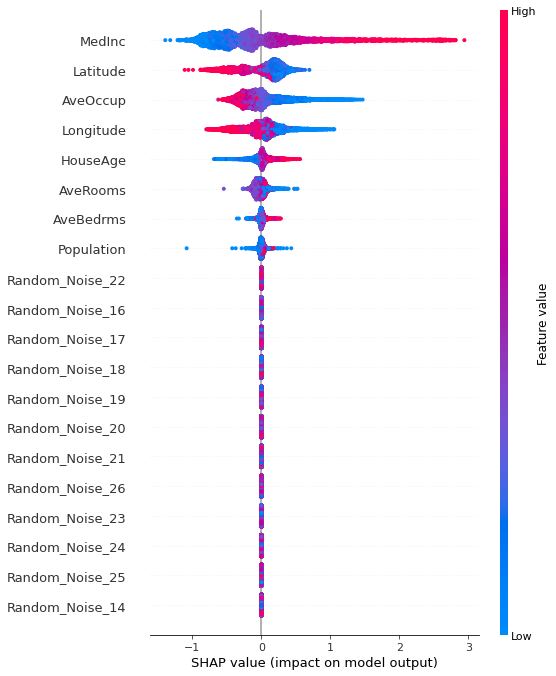

In [85]:
# 1. Summary Plot — глобальная важность признаков и влияние
shap.summary_plot(shap_values, X_test_uncorr, plot_type="dot")
# Интерпретация:
# - Каждая точка — один объект
# - По оси Y — признаки, отсортированы по важности.
# - По оси X — значение SHAP (вклад признака в предсказание).
# - Цвет — значение признака (синий — низкое, красный — высокое).
# - Распределение точек показывает, как разные значения признака влияют на предсказание.

/tmp/ipykernel_1315877/1420632375.py:2: FutureWarning: The NumPy global RNG was seeded by calling `np.random.seed`. In a future version this function will no longer use the global RNG. Pass `rng` explicitly to opt-in to the new behaviour and silence this warning.
  shap.summary_plot(shap_values, X_test_uncorr, plot_type="bar")


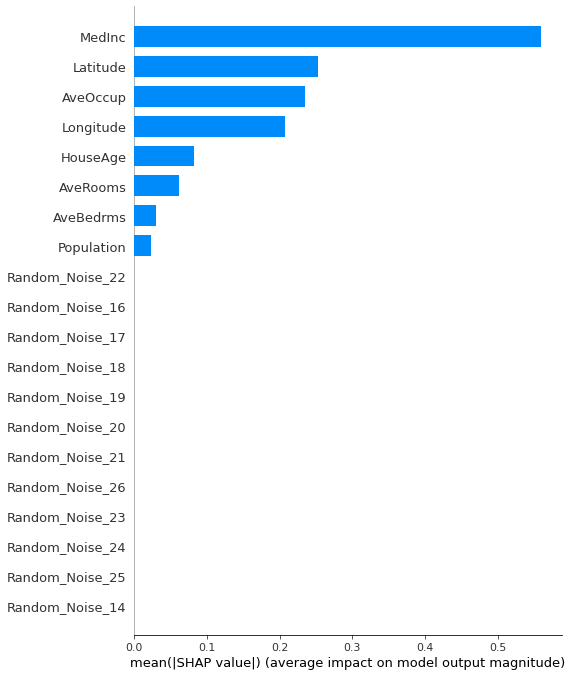

In [86]:
# 2. Bar Plot — средняя абсолютная важность признаков
shap.summary_plot(shap_values, X_test_uncorr, plot_type="bar")
# Интерпретация:
# - Показывает среднее по абсолютному значению SHAP для каждого признака.
# - Чем выше бар, тем важнее признак для модели.

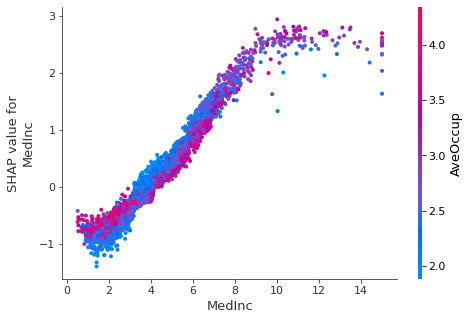

In [87]:
# 3. Dependence Plot — зависимость SHAP значения от значения признака
shap.dependence_plot("MedInc", shap_values, X_test_uncorr, feature_names)
# Интерпретация:
# Показывает, как изменение значения признака влияет на вклад в предсказание.
# Можно увидеть нелинейности, взаимодействия с другими признаками (цвет — другой признак).

In [88]:
# 4. Force Plot — локальное объяснение отдельного предсказания
shap.force_plot(explainer.expected_value, shap_values[0,:], X_test_uncorr.iloc[0,:])
# Визуализация вклада каждого признака для одного объекта.
# Красные значения — увеличивают предсказание, синие — уменьшают.